In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [2]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'])
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %d"%k)
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [3]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [4]:
#test.run(10) # n runs in parallel (the cpu time might not be trustful)
test.runOneByOne(50)

----finished----alg: 0
----finished----alg: 1
----finished----alg: 2
----finished----alg: 3
----finished----alg: 4
----finished----alg: 5
----finished----alg: 6
----finished----alg: 7
----finished----alg: 8
----finished----alg: 9
----finished----alg: 10
----finished----alg: 11
----finished----alg: 12


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [56]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,247.124,153.399,592.658,237.206,22086,0.081,592.739
72,1,1,10,30,-512,512.000,382.518,145.361,462.697,459.012,16226,114.754,577.451
90,2,1,10,30,-512,512.000,0.001,0.001,0.002,0.001,19004,0.000,0.002
108,3,1,10,30,-512,512.000,3609.470,222.611,861.189,3609.040,21072,3161.370,4022.560
126,4,1,10,30,-512,512.000,1162.170,297.878,1125.170,1095.690,16208,688.525,1813.700
144,5,1,10,30,-512,512.000,-0.002,0.000,0.001,-0.002,15655,-0.002,-0.001
162,6,1,10,30,-512,512.000,1933.600,204.884,676.156,1850.790,22122,1610.230,2286.390
180,7,1,10,30,-512,512.000,5246.210,158.108,476.000,5226.350,17880,4992.790,5468.790
198,8,1,10,30,-512,512.000,2039.600,647.134,2076.090,2136.160,15927,1151.270,3227.360
216,9,1,10,30,-512,512.000,1983.420,333.976,1122.800,2012.400,19435,1388.090,2510.900


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

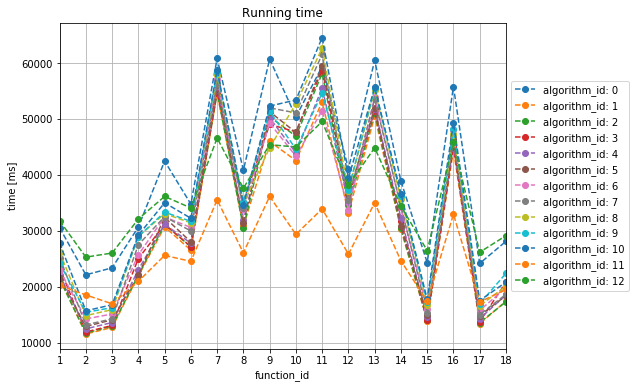

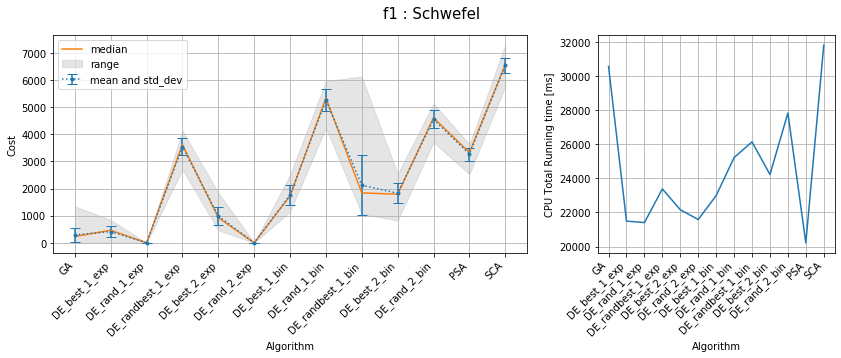

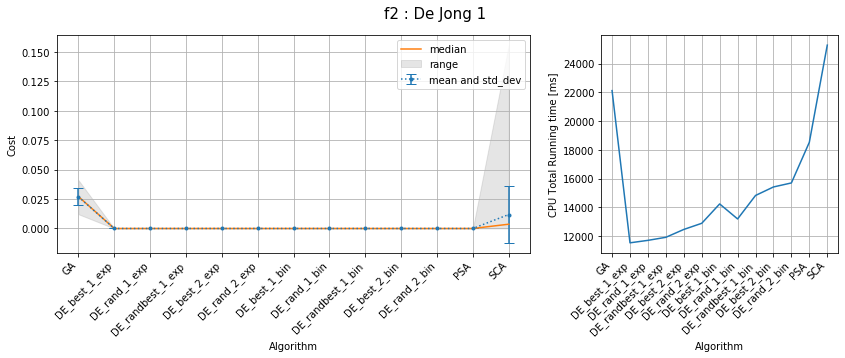

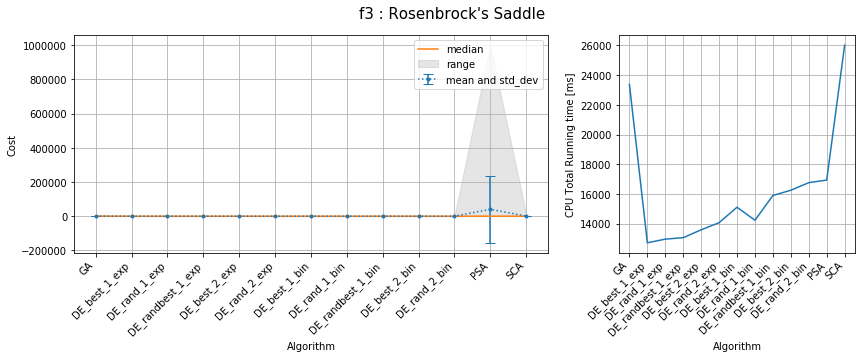

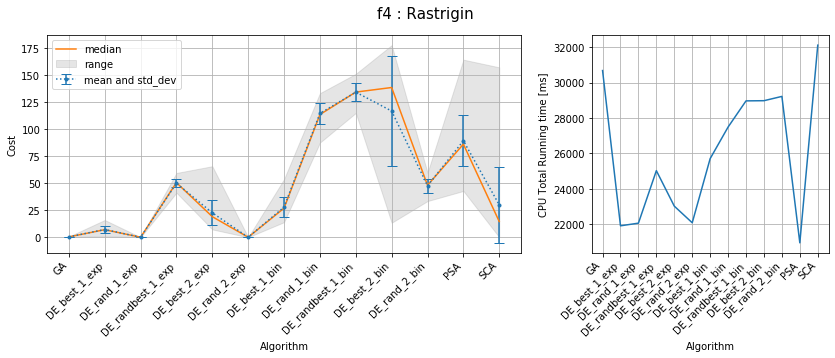

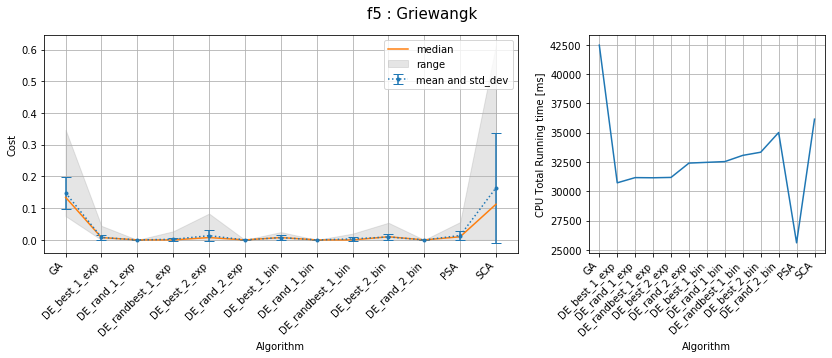

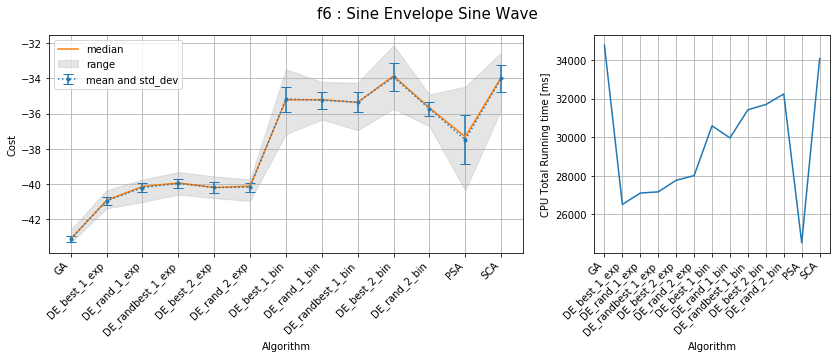

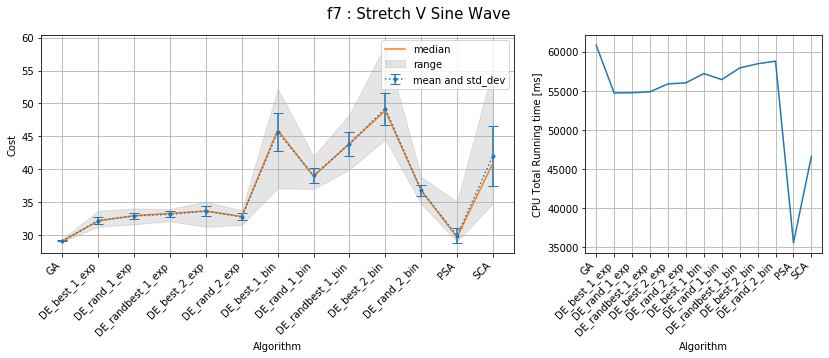

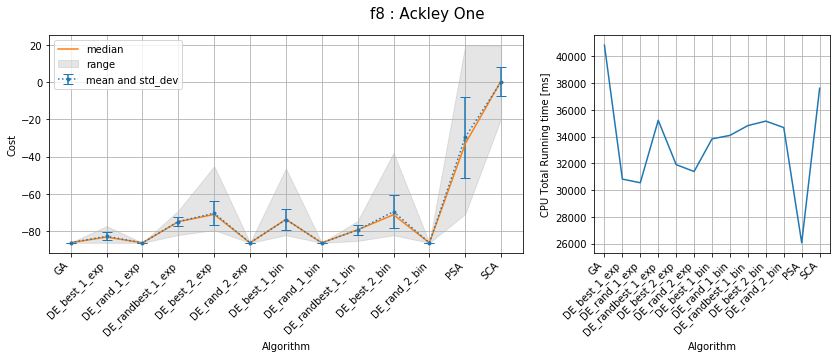

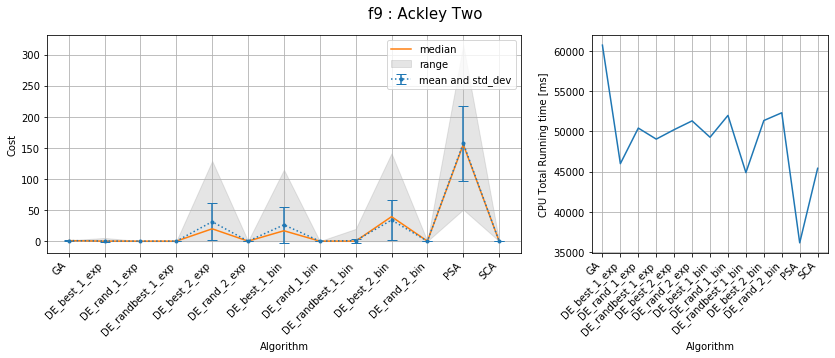

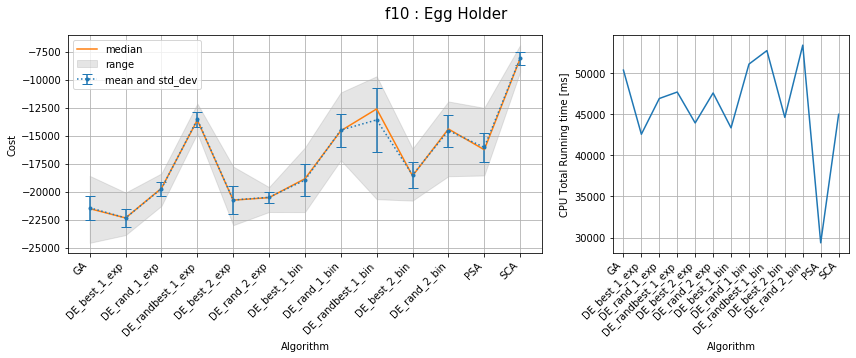

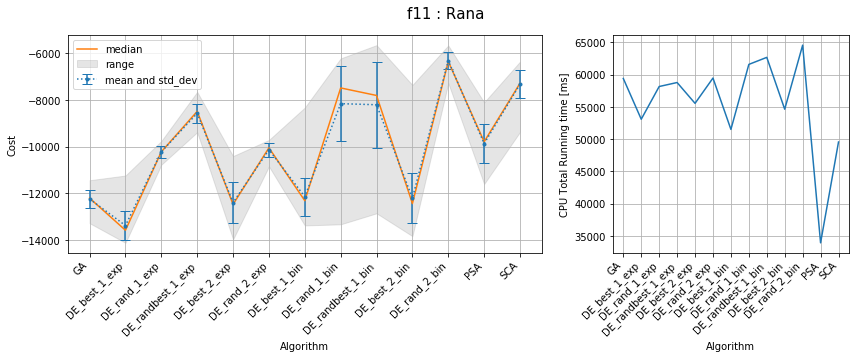

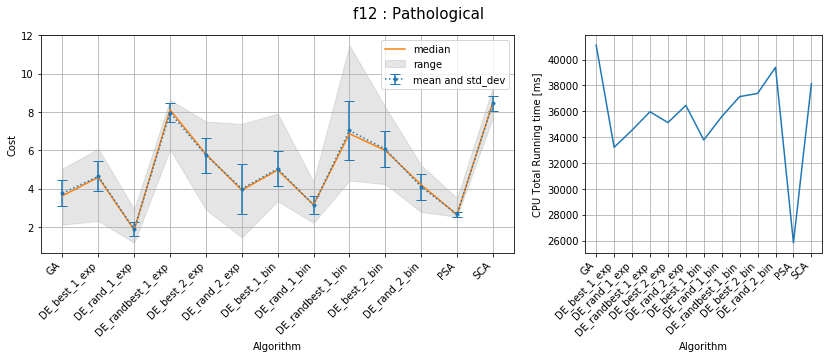

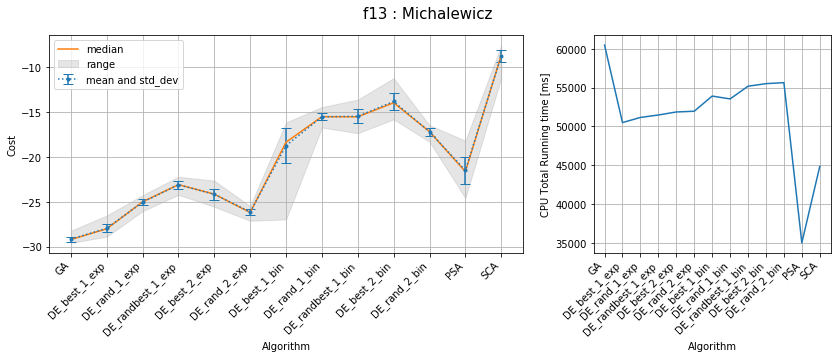

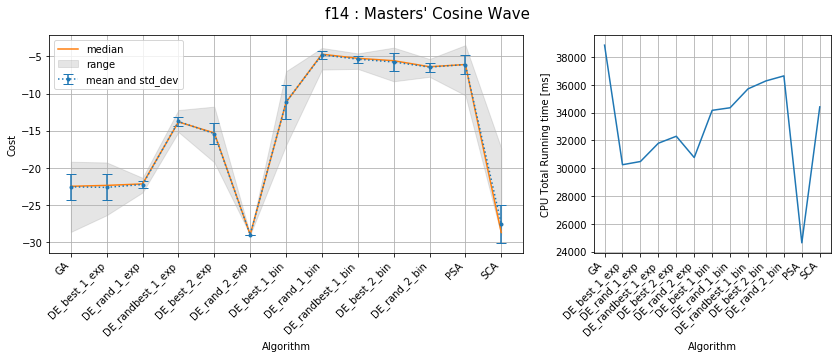

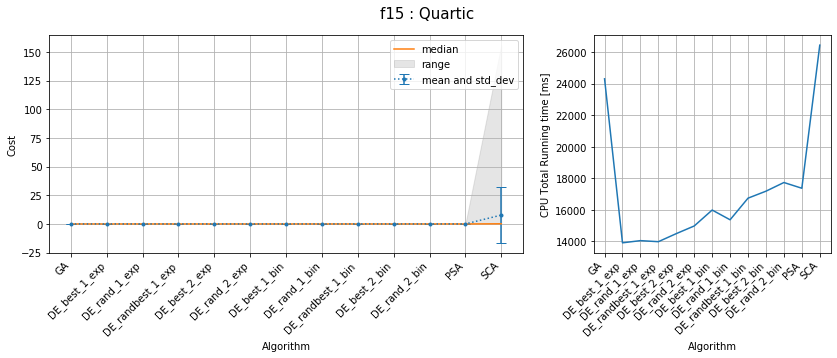

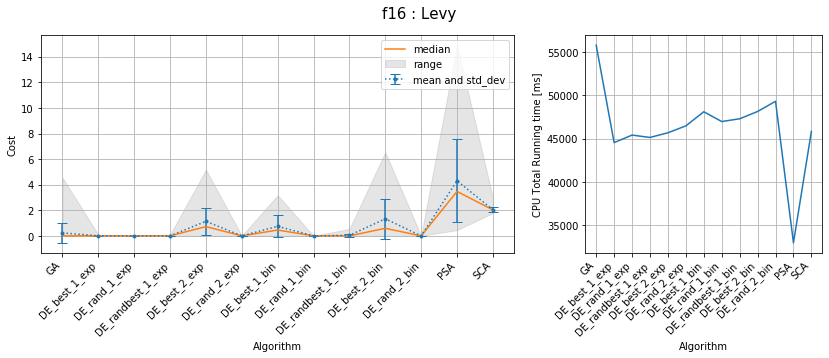

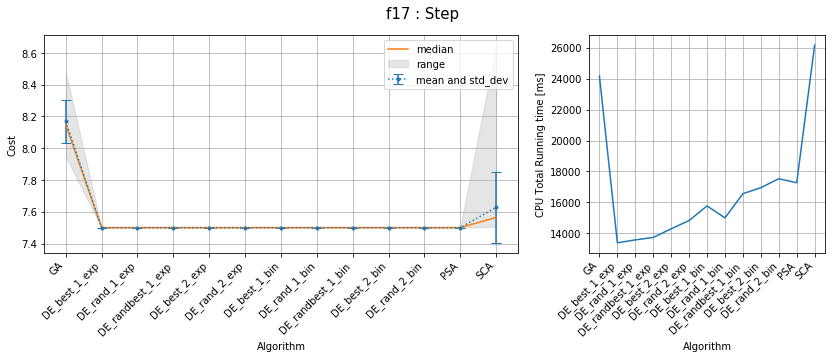

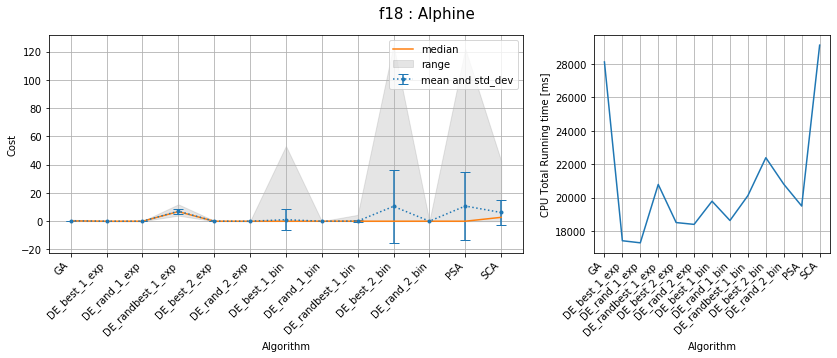

In [5]:
test.plot()

In [6]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
41,0,2,50,30,-100,100.000,0.027,0.007,0.029,0.027,22121.200,0.012,0.041
200,0,3,50,30,-100,100.000,257.352,884.297,6416.410,137.786,23371.600,22.558,6438.970
19,0,4,50,30,-30,30.000,0.326,0.093,0.441,0.329,30677.700,0.160,0.602
108,0,5,50,30,-500,500.000,0.148,0.049,0.272,0.134,42468.000,0.075,0.347
123,0,6,50,30,-30,30.000,-43.097,0.166,0.730,-43.116,34769.500,-43.326,-42.596
192,0,7,50,30,-30,30.000,29.109,0.084,0.406,29.082,60843.000,29.014,29.420
97,0,8,50,30,-32,32.000,-86.227,0.034,0.116,-86.232,40844.100,-86.288,-86.172
204,0,9,50,30,-32,32.000,0.912,0.188,0.725,0.853,60715.900,0.624,1.349
50,0,10,50,30,-500,500.000,-21442.100,1077.700,5979.960,-21521.800,50363.000,-24575.000,-18595.000


In [7]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
226,1,1,50,30,-512,512.000,413.589,204.703,846.204,462.697,21489.300,-0.001,846.203
183,2,1,50,30,-512,512.000,0.001,0.001,0.003,0.001,21405.800,-0.000,0.003
67,3,1,50,30,-512,512.000,3542.440,305.624,1428.860,3618.260,23376.400,2698.730,4127.590
35,4,1,50,30,-512,512.000,987.060,321.703,1386.780,925.399,22160.100,462.703,1849.480
178,5,1,50,30,-512,512.000,-0.002,0.000,0.002,-0.002,21582.000,-0.003,-0.001
130,6,1,50,30,-512,512.000,1757.670,359.702,1355.990,1728.670,22986.300,1147.530,2503.530
68,7,1,50,30,-512,512.000,5261.550,396.785,1730.240,5335.010,25214.300,4231.200,5961.440
142,8,1,50,30,-512,512.000,2124.900,1093.450,5061.780,1840.380,26134.600,1066.570,6128.350
189,9,1,50,30,-512,512.000,1824.540,364.970,1713.930,1789.090,24220.600,821.697,2535.630


# Read solution.csv, generate plot and latex report

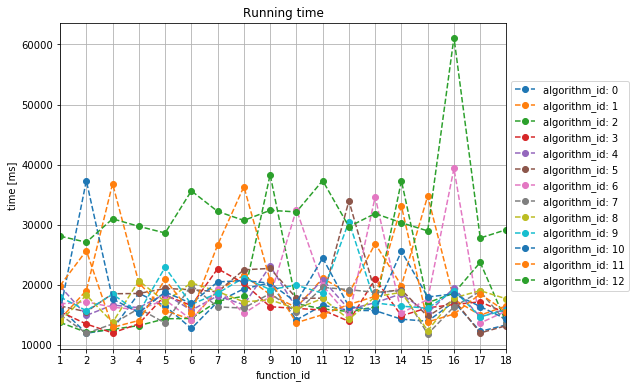

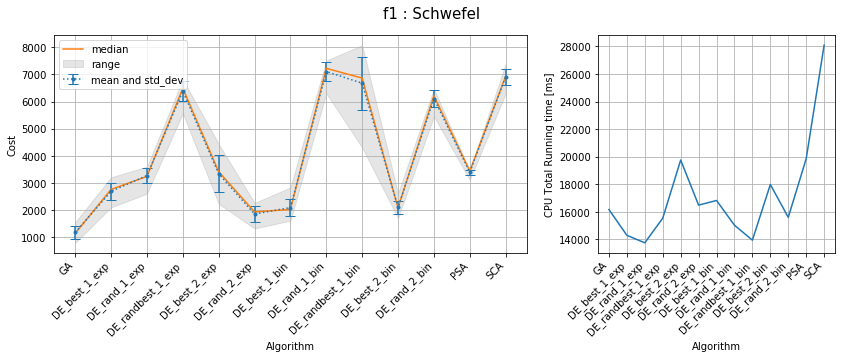

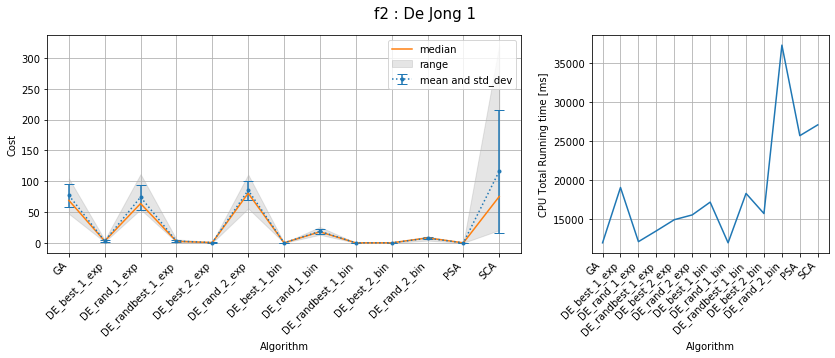

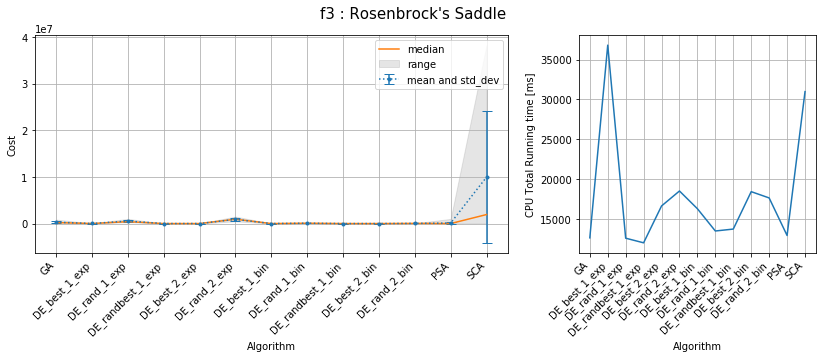

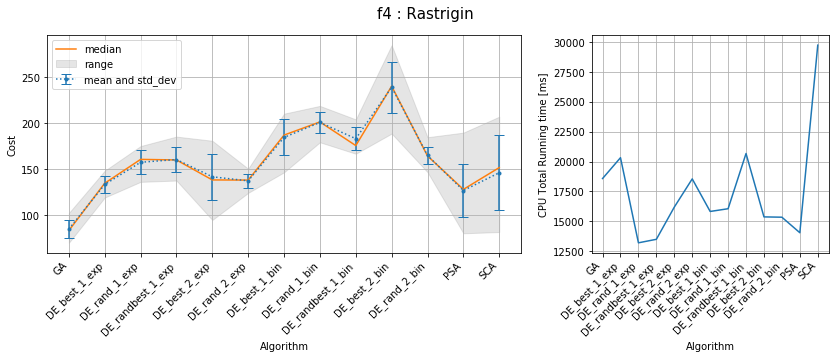

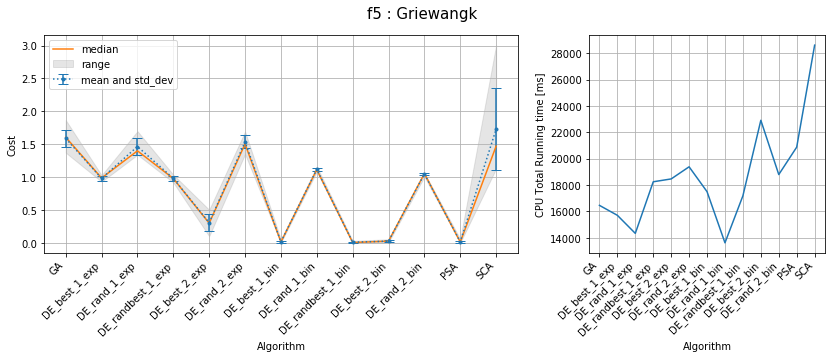

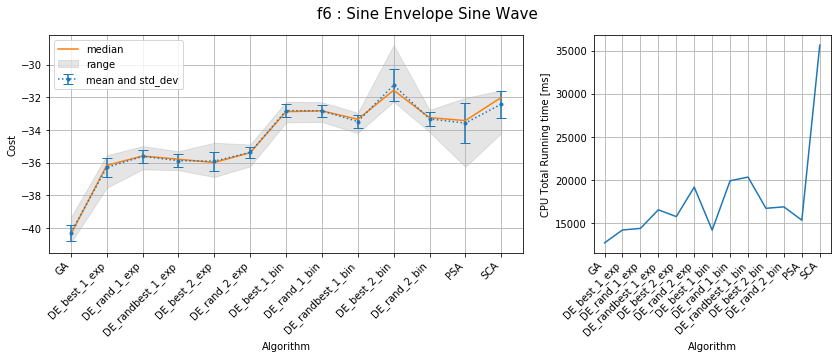

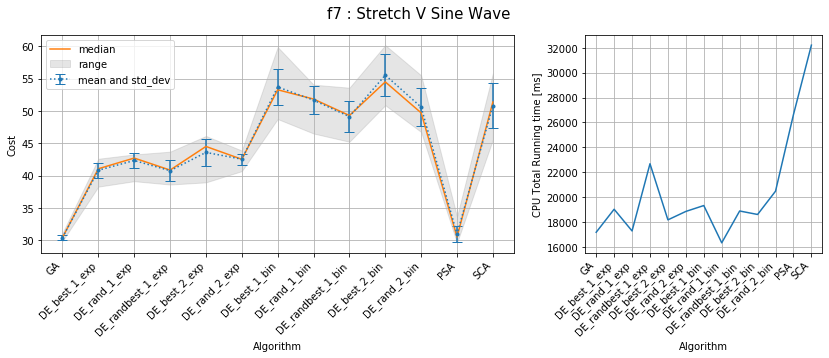

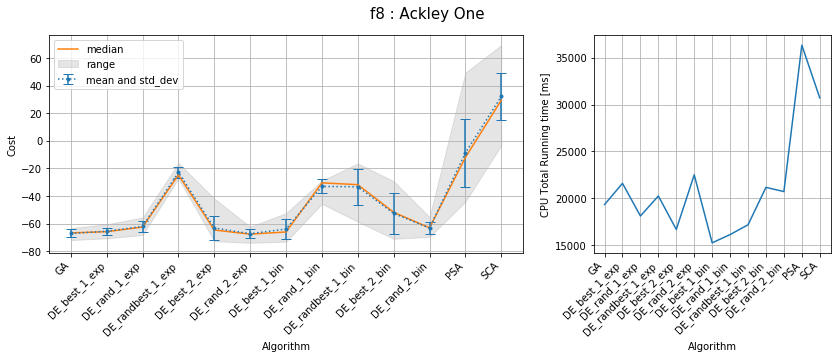

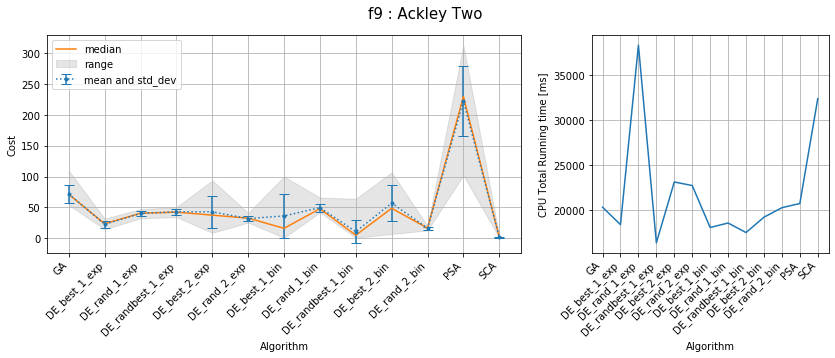

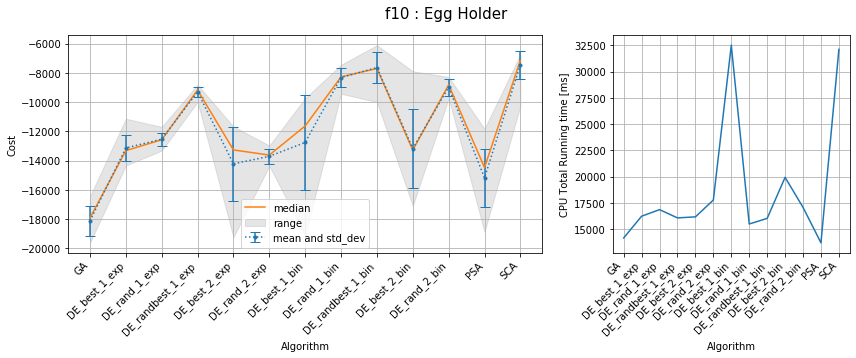

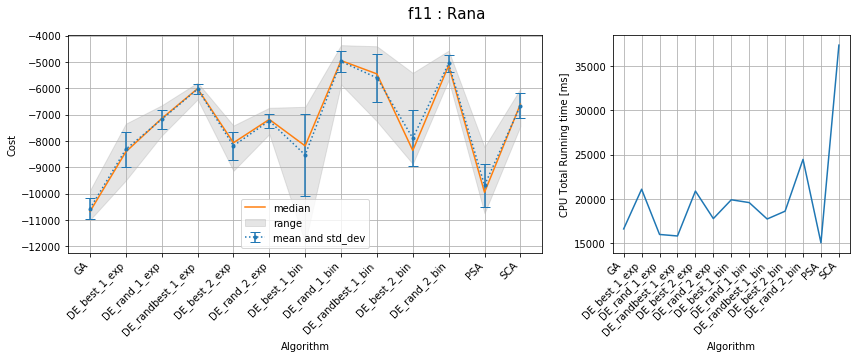

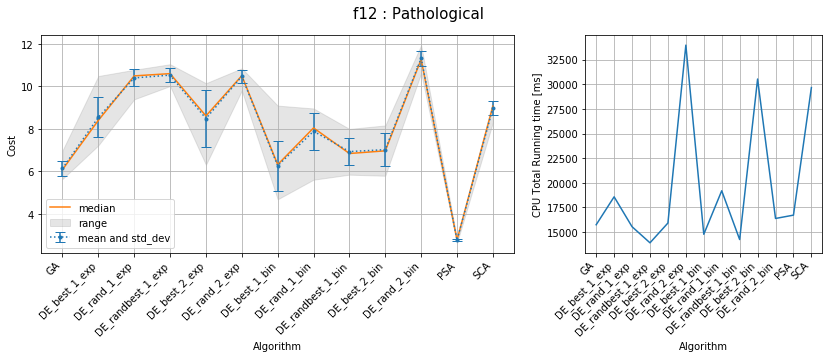

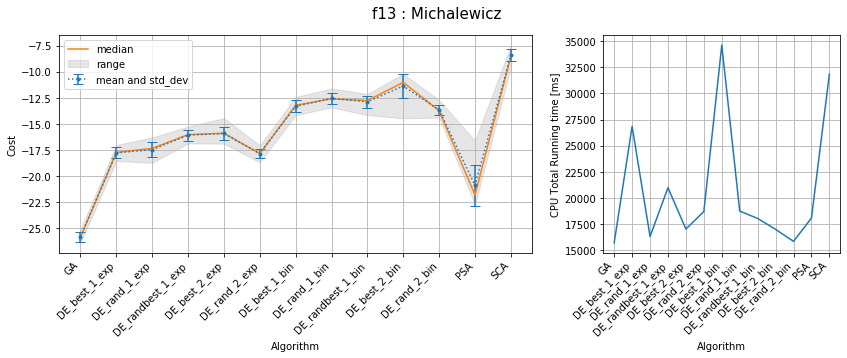

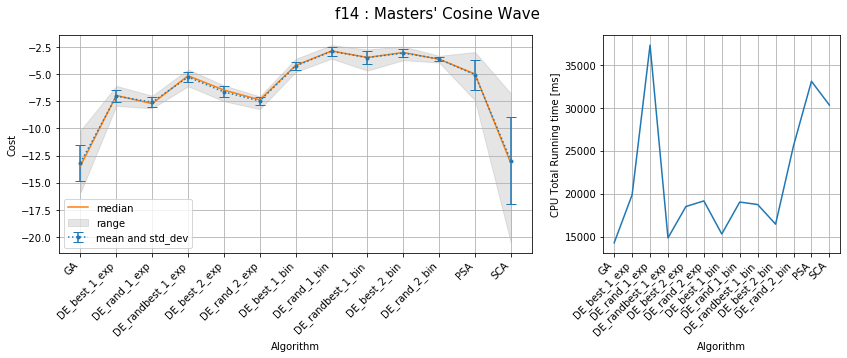

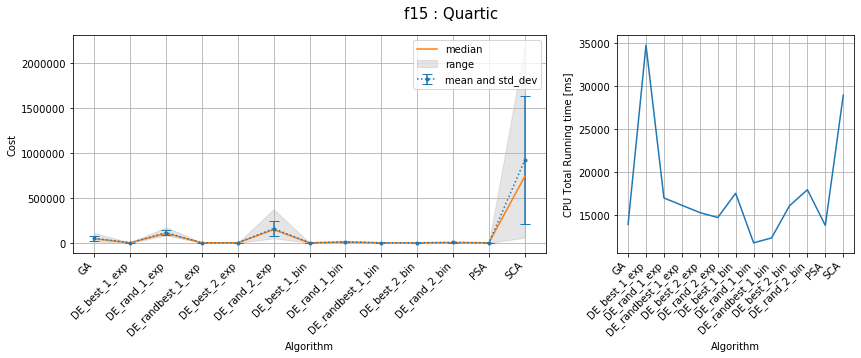

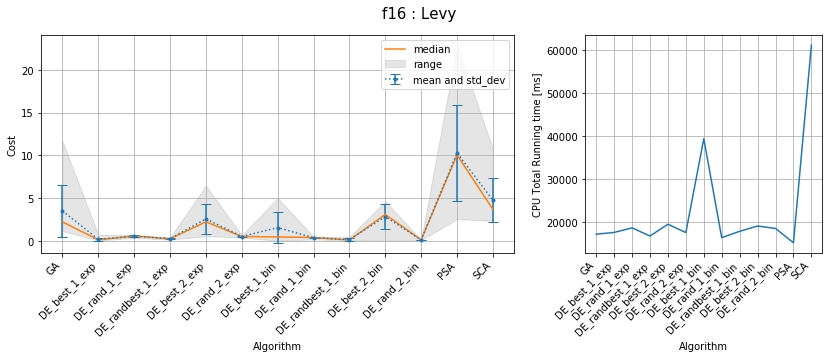

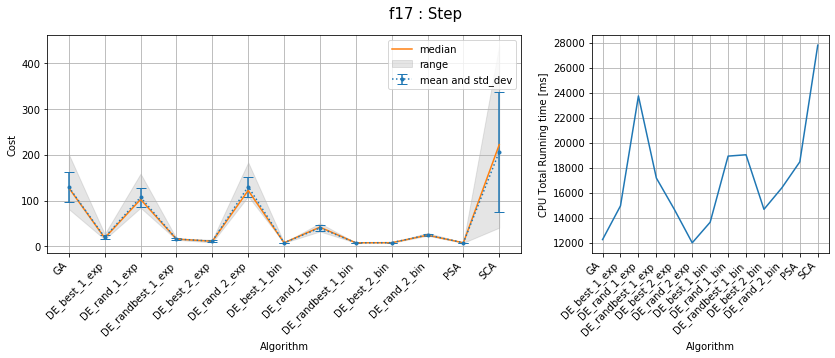

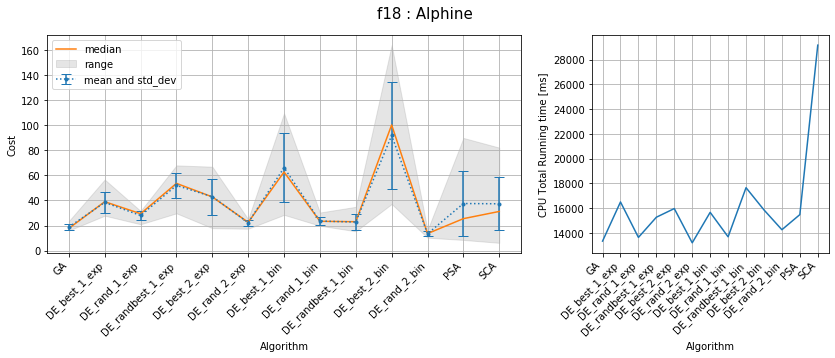

In [237]:
df=pd.read_csv("../out/optimization/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    #plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [8]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
226,1,1,50,30,-512,512.000,413.589,204.703,846.204,462.697,21489.300,-0.001,846.203
183,2,1,50,30,-512,512.000,0.001,0.001,0.003,0.001,21405.800,-0.000,0.003
67,3,1,50,30,-512,512.000,3542.440,305.624,1428.860,3618.260,23376.400,2698.730,4127.590
35,4,1,50,30,-512,512.000,987.060,321.703,1386.780,925.399,22160.100,462.703,1849.480
178,5,1,50,30,-512,512.000,-0.002,0.000,0.002,-0.002,21582.000,-0.003,-0.001
130,6,1,50,30,-512,512.000,1757.670,359.702,1355.990,1728.670,22986.300,1147.530,2503.530
68,7,1,50,30,-512,512.000,5261.550,396.785,1730.240,5335.010,25214.300,4231.200,5961.440
142,8,1,50,30,-512,512.000,2124.900,1093.450,5061.780,1840.380,26134.600,1066.570,6128.350
189,9,1,50,30,-512,512.000,1824.540,364.970,1713.930,1789.090,24220.600,821.697,2535.630


## support codes for latex report generation

In [10]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [11]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [12]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/figures - linux 1 cpu/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize""")
    print(df_fx.to_latex(index=False))
    print("""\\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # save the good algorithms after the hypothesis testing
    good_alg = []
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(" P value: %f   "%p)
                print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))
                good_alg.append(row["algorithm"])
    
    return good_alg

print_latex_function(8)

\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &   time\_ms \\
\midrule
                GA & -86.227 &    0.034 & -86.232 &    -86.288 &    -86.172 & 40844.100 \\
     DE\_best\_1\_exp & -82.798 &    2.124 & -83.265 &    -86.333 &    -77.374 & 30825.100 \\
     DE\_rand\_1\_exp & -86.333 &    0.000 & -86.333 &    -86.333 &    -86.333 & 30550.000 \\
 DE\_randbest\_1\_exp & -74.903 &    2.393 & -74.975 &    -82.121 &    -69.043 & 35223.000 \\
     DE\_best\_2\_exp & -70.404 &    6.608 & -71.073 &    -79.485 &    -45.173 & 31906.100 \\
     DE\_rand\_2\_exp & -86.333 &    0.000 & -86.333 &    -86.333

['DE_rand_2_exp', 'DE_rand_2_bin']

## Print latex

In [13]:
function_list = df_s["function_id"].unique()
good_algs = []
for i in function_list:
    good_algs.append(print_latex_function(i))

\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &   time\_ms \\
\midrule
                GA &  291.715 &  252.889 &  233.445 &      0.065 &   1342.860 & 30556.100 \\
     DE\_best\_1\_exp &  413.589 &  204.703 &  462.697 &     -0.001 &    846.203 & 21489.300 \\
     DE\_rand\_1\_exp &    0.001 &    0.001 &    0.001 &     -0.000 &      0.003 & 21405.800 \\
 DE\_randbest\_1\_exp & 3542.440 &  305.624 & 3618.260 &   2698.730 &   4127.590 & 23376.400 \\
     DE\_best\_2\_exp &  987.060 &  321.703 &  925.399 &    462.703 &   1849.480 & 22160.100 \\
     DE\_rand\_2\_exp &   -0.002 &    0.000 &   -0.002 & 

/home/c/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


## get algorithms with similar result comparing to the best

In [28]:
good_algs_s = [", ".join(i) for i in good_algs]
good_algs_s

['',
 'DE_best_2_exp',
 'DE_best_2_exp, PSA',
 '',
 '',
 '',
 '',
 'DE_rand_2_exp, DE_rand_2_bin',
 'DE_best_1_exp, DE_randbest_1_bin',
 '',
 '',
 '',
 '',
 '',
 'DE_best_1_exp, DE_randbest_1_exp, DE_best_2_exp, DE_rand_2_exp, DE_randbest_1_bin',
 'DE_best_1_exp, DE_randbest_1_exp',
 'DE_rand_1_exp, DE_randbest_1_exp, DE_rand_2_exp, DE_best_1_bin, DE_rand_1_bin, DE_randbest_1_bin, DE_best_2_bin, DE_rand_2_bin',
 'DE_best_2_exp, DE_best_1_bin, DE_randbest_1_bin']

In [29]:
df_similar=pd.DataFrame(list(zip(function_list,good_algs_s)), columns = ['function_id','similar_result'])

# print summary table

In [16]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
41,0,2,50,30,-100,100.000,0.027,0.007,0.029,0.027,22121.200,0.012,0.041
200,0,3,50,30,-100,100.000,257.352,884.297,6416.410,137.786,23371.600,22.558,6438.970
19,0,4,50,30,-30,30.000,0.326,0.093,0.441,0.329,30677.700,0.160,0.602
108,0,5,50,30,-500,500.000,0.148,0.049,0.272,0.134,42468.000,0.075,0.347
123,0,6,50,30,-30,30.000,-43.097,0.166,0.730,-43.116,34769.500,-43.326,-42.596
192,0,7,50,30,-30,30.000,29.109,0.084,0.406,29.082,60843.000,29.014,29.420
97,0,8,50,30,-32,32.000,-86.227,0.034,0.116,-86.232,40844.100,-86.288,-86.172
204,0,9,50,30,-32,32.000,0.912,0.188,0.725,0.853,60715.900,0.624,1.349
50,0,10,50,30,-500,500.000,-21442.100,1077.700,5979.960,-21521.800,50363.000,-24575.000,-18595.000


In [17]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[int(label)]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

/home/c/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSA,SCA
0,1,291.715,413.589,0.001,3542.440,987.060,-0.002,1757.670,5261.550,2124.900,1824.540,4551.430,3271.220,6546.260
1,2,0.027,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012
2,3,257.352,27.969,27.116,30.528,46.667,42.242,30.677,31.228,29.792,6.766,50.293,40247.300,665.449
3,4,0.326,7.144,0.001,49.952,22.547,0.000,27.855,114.483,134.128,116.669,47.581,89.168,29.896
4,5,0.148,0.008,0.000,0.002,0.013,0.000,0.007,0.000,0.003,0.009,0.000,0.014,0.164
5,6,-43.097,-40.954,-40.193,-39.959,-40.188,-40.172,-35.180,-35.246,-35.355,-33.936,-35.725,-37.483,-34.012
6,7,29.109,32.202,32.902,33.166,33.636,32.756,45.657,39.051,43.853,49.218,36.816,29.904,42.062
7,8,-86.227,-82.798,-86.333,-74.903,-70.404,-86.333,-73.816,-86.333,-79.442,-69.564,-86.333,-29.518,0.245
8,9,0.912,0.155,0.000,0.000,31.279,0.000,26.216,0.000,0.754,33.966,0.000,157.429,0.004
9,10,-21442.100,-22349.800,-19745.600,-13548.600,-20752.800,-20505.900,-18974.300,-14504.400,-13595.400,-18519.800,-14551.900,-16045.600,-8083.420


\begin{tabular}{rrrrrrrrrrrrrr}
\toprule
 function\_id &         GA &  DE\_best\_1\_exp &  DE\_rand\_1\_exp &  DE\_randbest\_1\_exp &  DE\_best\_2\_exp &  DE\_rand\_2\_exp &  DE\_best\_1\_bin &  DE\_rand\_1\_bin &  DE\_randbest\_1\_bin &  DE\_best\_2\_bin &  DE\_rand\_2\_bin &        PSA &       SCA \\
\midrule
           1 &    291.715 &        413.589 &          0.001 &           3542.440 &        987.060 &         -0.002 &       1757.670 &       5261.550 &           2124.900 &       1824.540 &       4551.430 &   3271.220 &  6546.260 \\
           2 &      0.027 &          0.000 &          0.000 &              0.000 &          0.000 &          0.000 &          0.000 &          0.000 &              0.000 &          0.000 &          0.000 &      0.000 &     0.012 \\
           3 &    257.352 &         27.969 &         27.116 &             30.528 &         46.667 &         42.242 &         30.677 &         31.228 &             29.792 &          6.766 &         50.293 &  40247.300 &   66

In [18]:
df_result

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSA,SCA
0,1,291.715,413.589,0.001,3542.440,987.060,-0.002,1757.670,5261.550,2124.900,1824.540,4551.430,3271.220,6546.260
1,2,0.027,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012
2,3,257.352,27.969,27.116,30.528,46.667,42.242,30.677,31.228,29.792,6.766,50.293,40247.300,665.449
3,4,0.326,7.144,0.001,49.952,22.547,0.000,27.855,114.483,134.128,116.669,47.581,89.168,29.896
4,5,0.148,0.008,0.000,0.002,0.013,0.000,0.007,0.000,0.003,0.009,0.000,0.014,0.164
5,6,-43.097,-40.954,-40.193,-39.959,-40.188,-40.172,-35.180,-35.246,-35.355,-33.936,-35.725,-37.483,-34.012
6,7,29.109,32.202,32.902,33.166,33.636,32.756,45.657,39.051,43.853,49.218,36.816,29.904,42.062
7,8,-86.227,-82.798,-86.333,-74.903,-70.404,-86.333,-73.816,-86.333,-79.442,-69.564,-86.333,-29.518,0.245
8,9,0.912,0.155,0.000,0.000,31.279,0.000,26.216,0.000,0.754,33.966,0.000,157.429,0.004
9,10,-21442.100,-22349.800,-19745.600,-13548.600,-20752.800,-20505.900,-18974.300,-14504.400,-13595.400,-18519.800,-14551.900,-16045.600,-8083.420


## get best cost without time

In [27]:
df_best = df_result[["function_id"]]
df_best["best_algorithm"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

/home/c/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/c/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,best_algorithm,best_cost
0,1,DE_rand_2_exp,-0.002
1,2,PSA,0.000
2,3,DE_best_2_bin,6.766
3,4,DE_rand_2_exp,0.000
4,5,DE_rand_2_bin,0.000
5,6,GA,-43.097
6,7,GA,29.109
7,8,DE_rand_1_exp,-86.333
8,9,DE_rand_2_bin,0.000
9,10,DE_best_1_exp,-22349.800


In [30]:
df_best_similar = df_best.merge(df_similar, on=["function_id"], how='left') 
df_best_similar

,function_id,best_algorithm,best_cost,similar_result
0,1,DE_rand_2_exp,-0.002,
1,2,PSA,0.000,DE_best_2_exp
2,3,DE_best_2_bin,6.766,"DE_best_2_exp, PSA"
3,4,DE_rand_2_exp,0.000,
4,5,DE_rand_2_bin,0.000,
5,6,GA,-43.097,
6,7,GA,29.109,
7,8,DE_rand_1_exp,-86.333,"DE_rand_2_exp, DE_rand_2_bin"
8,9,DE_rand_2_bin,0.000,"DE_best_1_exp, DE_randbest_1_bin"
9,10,DE_best_1_exp,-22349.800,


In [31]:
print(df_best_similar.to_latex(index=False))

\begin{tabular}{rlrl}
\toprule
 function\_id & best\_algorithm &  best\_cost &                                     similar\_result \\
\midrule
           1 &  DE\_rand\_2\_exp &     -0.002 &                                                    \\
           2 &            PSA &      0.000 &                                      DE\_best\_2\_exp \\
           3 &  DE\_best\_2\_bin &      6.766 &                                 DE\_best\_2\_exp, PSA \\
           4 &  DE\_rand\_2\_exp &      0.000 &                                                    \\
           5 &  DE\_rand\_2\_bin &      0.000 &                                                    \\
           6 &             GA &    -43.097 &                                                    \\
           7 &             GA &     29.109 &                                                    \\
           8 &  DE\_rand\_1\_exp &    -86.333 &                       DE\_rand\_2\_exp, DE\_rand\_2\_bin \\
           9 &  DE\_rand\_2\_bin &    

## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
